# EE5104 Assigment 1 - CNN design, training and optimization
In this assignment, you will build and train a CNN from scratch using Tensorflow and Keras. You will then train your model on the ImageNette dataset (a subset of the ImageNet dataset with 10 relatively easy classes).

You will use Tensorboard to assess the performance of your model. In particular, you will examine the validation accuracy and validation loss.
You will also display the confusion matrix, precision, recall and F1 score for your model.

You will then use a selection of training optimization techniques to improve your model performance (again, validation accuracy and validation loss).

Finally, you will optimize your model with the TFLite toolbox, and compare the performance of your optimized model vs the original model

It is very highly recommended that you use Kaggle for this assignment, as Kaggle will give you 30 hours per week of GPU access for free, once you sign up. It is also very convenient for importing datasets.

## Assigment Details
- This assigment is worth 15% of your final grade.
- The submission deadline is Midnight, Sunday the 8th of February
- You will submit the notebook ipnb file via Canvas. Include all results, comments and discussion points within the notebook file

## Template notebook
You will be given a template notebook for this assignment. This template notebook includes:
- The libaries you'll need
- Instructions on how to add the ImageNette dataset
- Helper scripts for image pre-processing and dataset configuration
- Misc. instructions

## Kaggle setup
Open www.kaggle.com, and create an account. Once you create an account, verify with your phone number, and this will give you access to GPUs for training. You can do this by clicking on the account button in the top right of the Kaggle homepage. You can also see your GPU usage quota here.


## Import ImageNette Dataset
You can import the dataset we'll use for this assignment using either "File->Add Data", or via the menu on the right side of the Kaggle interface. - From the "Add Data" menu, search for "imagenette". There are a few versions, so select "Imagenette" uploaded by "asjad2024" (324mB). 

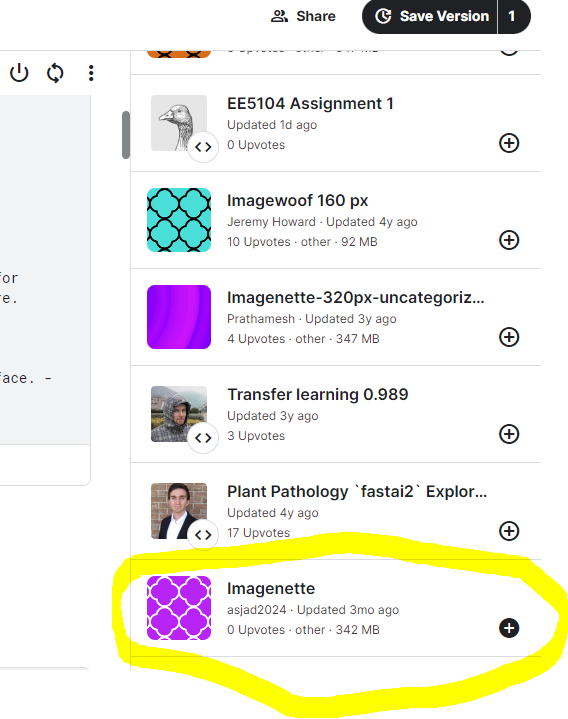

This will download the tarball containing the image data.

# WARNING!!!!!! files stored in the "Output" folder are not stored permanently! Download any model you want to keep if you want to avoid losing it!!!

## Import libraries we'll need
This is a complete list of all of the libraries you will need for this assignment

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tarfile

# Some housekeeping libraries
from warnings import filterwarnings
import gc
import subprocess

## Dataset preparation
- Extract the tar file
- Define the folder locations


In [2]:
# defile the filepaths you'll be using
file_path = '//kaggle/input/34234234/imagenette2-320.tgz'
output_path= '/kaggle/working'

# Open the tar.gz file
with tarfile.open(file_path,'r:*') as tar:
    # Extract all files
    tar.extractall(path=output_path)
    tar.close()

In [7]:
# define folder locations
train_dir = '/kaggle/working/imagenette2-320/train'
val_dir = '/kaggle/working/imagenette2-320/val'


## Label the data
If you explore the files you just extracted, you should see a train and val folder. Each contain subfolders with an alphanumeric name. These are the ImageNet labels for the objects. We need to define a dictionary to associate a human readible label with each of these alphanumeric names.

In [8]:
# create a dictionary to label the data
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

# we'll need a basic array later...
labels_array = np.array(list(lbl_dict.values()))

for key, value in lbl_dict.items():
    print(f"{key}: {value}")

n01440764: tench
n02102040: English springer
n02979186: cassette player
n03000684: chain saw
n03028079: church
n03394916: French horn
n03417042: garbage truck
n03425413: gas pump
n03445777: golf ball
n03888257: parachute


## Configuring the dataset
In the next section, we will configure the training and validation sets. 

We will also pre-process the images. To do this, we rescale the images to 224*224 pixels (standard for many object classifiers), and set the range from 0..1.0. 


In [9]:
# Set up arrays for train and val. "X" are the input images, "y" are the validation labels.
X_train = []
y_train = []

X_val = []
y_val = []

image_size = 224

for index, (key, value) in enumerate(lbl_dict.items()):
    folderPath = os.path.join('/kaggle/working/imagenette2-320','train', key)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size)).astype(np.float32)
        img /= 255.
        X_train.append(img)
        y_train.append(index)
        
for index, (key, value) in enumerate(lbl_dict.items()):
    folderPath = os.path.join('/kaggle/working/imagenette2-320','val',key)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size)).astype(np.float32)
        img /= 255.
        X_val.append(img)
        y_val.append(index)


        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

# save a bit of ram
del img

100%|██████████| 390/390 [00:00<00:00, 674.11it/s]


## Set up one-hot encoding
So far, the y_train and y_val are set up as a single number from 0-9 (10 classes). We will now convert the flags to one-hot encoded i.e. class 2 = [0,0,1,0,0,0,0,0,0,0]

In [16]:
# perform one-hot encoding

y_train = tf.keras.utils.to_categorical(y_train)

y_val = tf.keras.utils.to_categorical(y_val)


## Create the classifier model.
Create a function that implements a basic CNN using Tensorflow and Keras. 

Define the input shape (224,224,3) and the number of classes = 10.

The starting network should have:
- an input layer with the same shape as the input image
- a convolution layer with 32 3x3 filters, a relu activation and same padding
- a max pooling layer with 2x2 pool size
- a convolution layer with 64 3x3 filters, relu activation and same padding
- a max pooling layer with 2x2 pool size
- a convolution layer with 128 3x3 filters, relu activation and same padding
- a max pooling layer with 2x2 pool size
- a Flatten layer
- a Dense later with 256 units and relu activation
- a Dense output layer with a softmax activation

Once the model is defined, create an instance of the classifier model and display the model summary


In [6]:
# define your classifier function here
def SimpleClassifier(input_shape=(224, 224, 3), num_classes=10):

    model=keras.Sequential([
        Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=input_shape),
        MaxPooling2D(pool_size=2),
    
   
        Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'),
        MaxPooling2D(pool_size=2),
    

        Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'),
        MaxPooling2D(pool_size=2),
    
        Flatten(),
        layers.Dense(units=256,activation='relu'),
        layers.Dense(num_classes, activation='softmax')
        
    ])
    return model
    


# Create an instance of the SimpleClassifier model
model = SimpleClassifier()

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,186 (98.37 MB)

 Trainable params: 25,786,186 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

## Create a tensorboard to track model learning
Tensorboards are very useful for tracking model training. For more details, check out https://zito-relova.medium.com/tensorboard-tutorial-5d482d270f08
 and https://www.kaggle.com/code/aagundez/using-tensorboard-in-kaggle-kernels. We will also create a ModelCheckpoint to save the best version of the model.
 
 Note: there seem to be issues with Kaggle and Tensorboard, so for now, we will just plot the output inline with a function defined below.

In [7]:
# load tensorboard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/kaggle/working/simpleClassifier.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


## Configure and train the model
In this block, we will do the following:
- Configure the learning rate using "ReduceLROnPlateau" finction, to reduce the learning rate when we get closer to model convergence
- Compile the model. Use categorical_crossentropy loss, the Adam optimizer, and accuracy as the metrics
- Fit the model to the training data with the model.fit function. Explicitly set the validation data to (X_val, y_val). For now, set train for 15 epochs with a batch size of 32


In [8]:
# define the learning rate using ReduceLRONPlateau function
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


# compile your model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# fit the model to your training data
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15, 
                    batch_size=32, 
                    callbacks=[tensorboard, checkpoint,reduce_lr])


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3014 - loss: 2.3310
Epoch 1: val_accuracy improved from -inf to 0.55236, saving model to /kaggle/working/simpleClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.3018 - loss: 2.3291 - val_accuracy: 0.5524 - val_loss: 1.3426 - learning_rate: 0.0010
Epoch 2/15
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6240 - loss: 1.1638
Epoch 2: val_accuracy improved from 0.55236 to 0.59134, saving model to /kaggle/working/simpleClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.6241 - loss: 1.1634 - val_accuracy: 0.5913 - val_loss: 1.2607 - learning_rate: 0.0010
Epoch 3/15
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7501 - loss: 0.7901
Epoch 3: val_accuracy improved from 0.59134 to 0.62955, saving model to /kaggle/working/simpleClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.7501 - loss: 0.7900 - val_accuracy: 0.6296 - val_loss: 1.2244 - l

## View the training results
You can check the training progress in realtime by going to localhost:6006 (in principle, seems to be an issue with Kaggle)

We will also set up a helper function below to plot the training results inline

In [23]:
# function to plot your training results
def plot_results(history, epochs):
    filterwarnings('ignore')

    epochs = [i for i in range(epochs)]
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
                 fontname='monospace',y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, marker='o',
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, marker='o',
               label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, marker='o',
               label ='Training Loss')
    ax[1].plot(epochs, val_loss, marker='o',
               label = 'Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

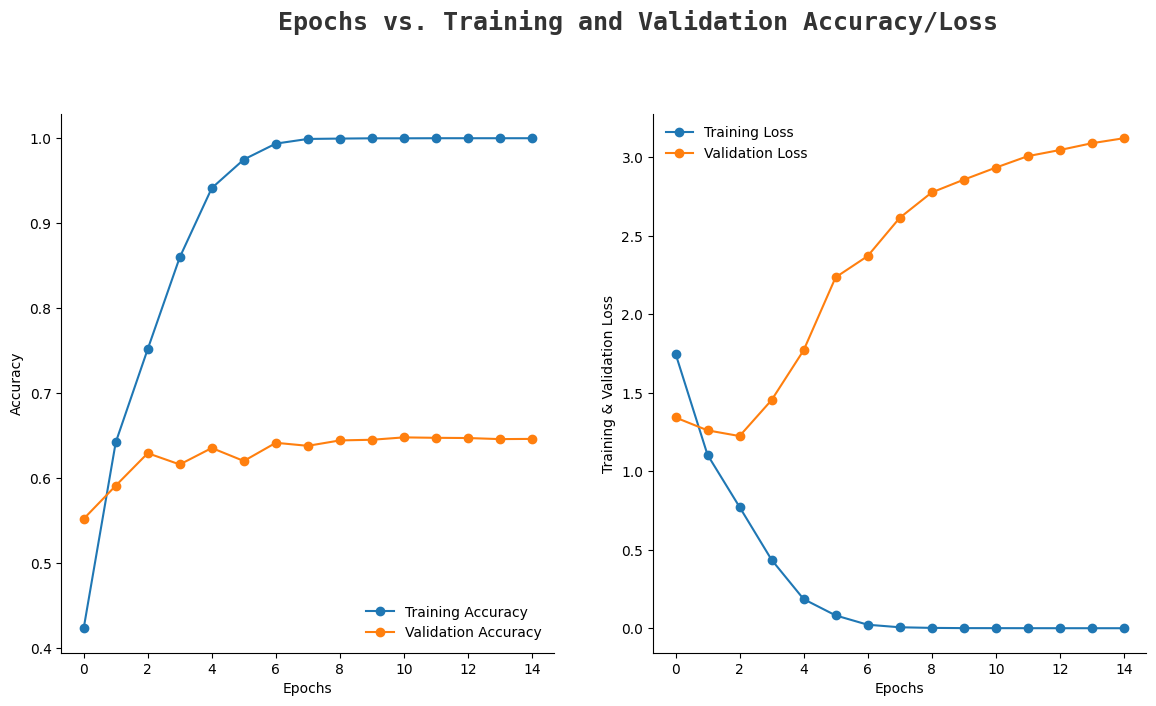

In [10]:
# plot the results
plot_results(history,epochs=15)

## Comment on the results from the simple classifier
Based on the training accuracy and loss, and the validation accuracy and loss, what can we say about the model performance? Insert answer here:

According to the graph, it can be seen that the training loss is gradually decreasing as the number of training turns (Epochs) increases,And as you can see from the orange curve in the image on the right the validation loss decreases initially but starts to rise after the third epochs.This situation means that the model is overfitting. Overfitting is a condition where the model performs well on the training data but performs poorly on the validation data.

The training accuracy and validation accuracy varied similarly to the first two parameters, which is a further indication of overfitting of the model，Overfitting is usually caused by high model complexity, insufficient training data, lack of regularization techniques, etc.


## Comments on training performance
Answer here...

The model learns faster in the early stages, with both training and validation losses decreasing and both training and validation accuracies increasing.The learning rate of the model starts to slow down in the middle and late stages, and it can be clearly observed that the validation loss gradually rises and then stabilizes.To address this problem, the model can be optimized using regularization, model complexity reduction (Dropout), and Data Augmentation

## Precision and recall
The code below will calculate the precision, recall, F1 and confusion matrix for your model. Comment on the results

## Comments on model precision and recall
Answer here

Based on the graphs that appear after running，from the graphs that appear after the run, it can be observed that the accuracy and recall of the model varies according to the different feature classes, and are generally around 0.65.The performance of category 3 (chainsaw) is the worst, with precision and recall of 0.50 and 0.46, respectively.Category 9 (parachute) has the best performance with precision and recall of 0.71 and 0.75 respectively.

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       387
           1       0.65      0.70      0.67       395
           2       0.63      0.67      0.65       357
           3       0.50      0.46      0.48       386
           4       0.69      0.70      0.69       409
           5       0.70      0.62      0.65       394
           6       0.65      0.69      0.67       389
           7       0.60      0.57      0.58       419
           8       0.66      0.62      0.64       399
           9       0.71      0.75      0.73       390

    accuracy                           0.65      3925
   macro avg       0.65      0.65      0.65      3925
weighted avg       0.65      0.65      0.65      3925



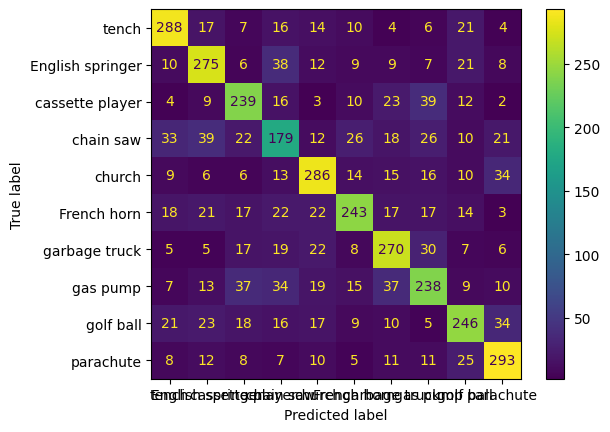

<Figure size 2000x2000 with 0 Axes>

In [13]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)


print(classification_report(y_val_new,pred))

cm = confusion_matrix(y_val_new,pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()


## Clean up
Before we run the next model, we need to clean up the workspace, particularly to free up some RAM. The code snippet below will do this.

In [ ]:
def clean_up(model=model):
    #delete the model
    del model

    # Clear TensorFlow session
    tf.keras.backend.clear_session()

    # Force garbage collection
    gc.collect()

In [15]:
clean_up(model=model)

## Optimize model performance
Without changing the number of epochs, modify the network to improve validation loss and accuracy. There are a number of ways to do this, including data augmentation, dropout, batch normalization, L1/L2 regularization etc. Experiment with these options and save your best performing result.

# 1.Data Augmentation

In [ ]:
# new model here(Data Augmentation):

from tensorflow.keras.layers import RandomRotation

def ImprovedClassifier1(input_shape=(224, 224, 3), num_classes=10):

# Create an instance of the SimpleClassifier model

    model=keras.Sequential([
        
        RandomRotation(factor=0.20),
        
    
        Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=input_shape),
        MaxPooling2D(pool_size=2),
    
   
        Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'),
        MaxPooling2D(pool_size=2),
    

        Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'),
        MaxPooling2D(pool_size=2),
    
        Flatten(),
        layers.Dense(units=256,activation='relu'),
        layers.Dense(num_classes, activation='softmax')
        
    ])
    return model
    


# Create an instance of the SimpleClassifier model
model = ImprovedClassifier1()

# Display model summary
model.summary()


In [33]:
# set up a tensorboard and save logs
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/kaggle/working/ImprovedClassifier.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [34]:
# define the learning rate using ReduceLRONPlateau function

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# compile your model

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# fit the model to your training data

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15,
                    batch_size=32,
                    callbacks=[tensorboard, checkpoint,reduce_lr])


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2445 - loss: 2.3237
Epoch 1: val_accuracy improved from -inf to 0.50293, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.2448 - loss: 2.3224 - val_accuracy: 0.5029 - val_loss: 1.4919 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5005 - loss: 1.4778
Epoch 2: val_accuracy improved from 0.50293 to 0.52561, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.5005 - loss: 1.4777 - val_accuracy: 0.5256 - val_loss: 1.4433 - learning_rate: 0.0010
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5451 - loss: 1.3319
Epoch 3: val_accuracy improved from 0.52561 to 0.55669, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.5452 - loss: 1.3318 - val_accuracy: 0.5567 - val_loss: 1.35

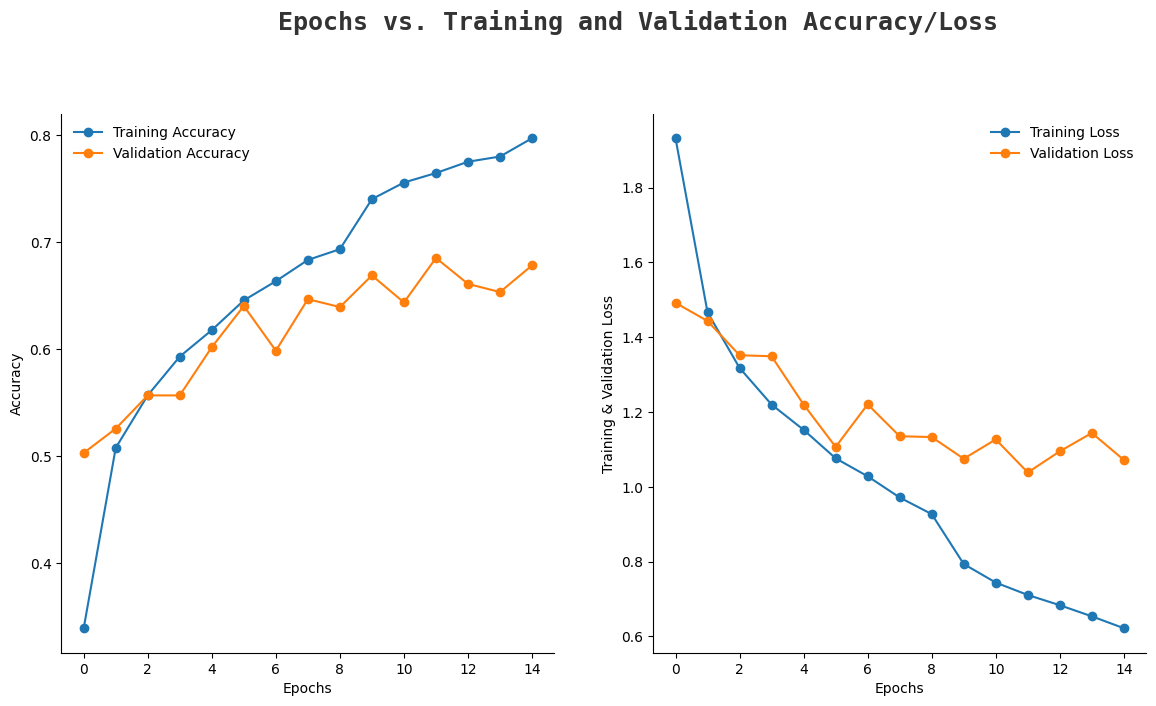

In [35]:
plot_results(history,epochs=15)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       387
           1       0.79      0.74      0.76       395
           2       0.66      0.71      0.69       357
           3       0.57      0.56      0.56       386
           4       0.63      0.77      0.69       409
           5       0.62      0.74      0.68       394
           6       0.71      0.64      0.68       389
           7       0.53      0.53      0.53       419
           8       0.65      0.69      0.67       399
           9       0.85      0.74      0.79       390

    accuracy                           0.68      3925
   macro avg       0.69      0.68      0.68      3925
weighted avg       0.69      0.68      0.68      3925



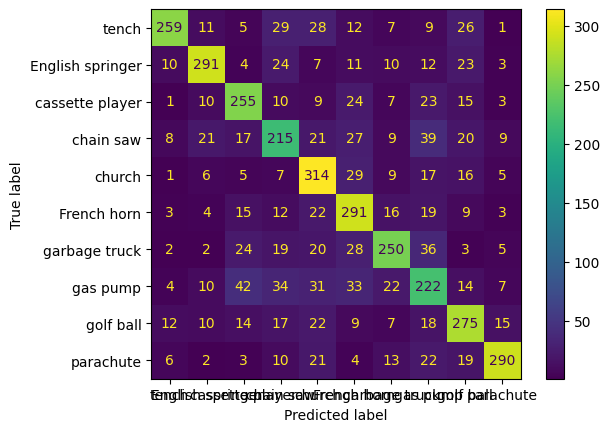

<Figure size 2000x2000 with 0 Axes>

In [36]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)


print(classification_report(y_val_new,pred))

cm = confusion_matrix(y_val_new,pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()

clean_up(model=model)

# Comment on the performance of the optimized model

Compare the performance of your optimized model vs the baseline model in terms of accuracy and model size. Comment on the benefits of model optimization for edge devices and embedded systems

This optimized model has the main addition of Data Augmentation techniques compared to the original model，It can transform the training data to generate more samples, increasing the diversity of the data and improving the generalization ability of the model.RandomRotation(factor=0.20) implies randomly rotating up to 20% of the available test samples to generate multiple samples for training and learning.

By looking at the graphs of accuracy and loss, it can be seen that the gap between the validation loss and training loss of the optimized model decreases, and the upward trend of the validation loss undergoes a sharp reduction compared to the original model.The overfitting problem of the model is mitigated，The generalization of the model has improved.

The average accuracy of the model rose to 0.68，however,more violent oscillations in the validation curve.This may be due to the fact that the optimization is a data augmentation with randomness, where the original detected image undergoes random rotation.Even so the data-enhanced optimization effectively mitigates the overfitting problem.However, one point worth noting is that this model appears to be underfitting,it is shown in the line graph as a low validation accuracy and is close to the training accuracy.,this may be because the intensity of regularization is too high, limiting the model's ability to learn.




# 2.Dropout

In [37]:
# new model here(Dropout):

def ImprovedClassifier2(input_shape=(224, 224, 3), num_classes=10):

# Create an instance of the SimpleClassifier model

    model=keras.Sequential([
        
        Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=input_shape),
        MaxPooling2D(pool_size=2),
    
   
        Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'),
        MaxPooling2D(pool_size=2),
    

        Conv2D(filters=128,kernel_size=3,activation='relu',padding='same),
        MaxPooling2D(pool_size=2),
    
        Flatten(),
        layers.Dense(units=256,activation='relu'),
        layers.Dropout(rate=0.3),
        layers.Dense(num_classes, activation='softmax')
        
    ])
    return model
    


# Create an instance of the SimpleClassifier model
model = ImprovedClassifier2()

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,247,242 (84.87 MB)

 Trainable params: 22,247,242 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# set up a tensorboard and save logs
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/kaggle/working/ImprovedClassifier.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [39]:
# define the learning rate using ReduceLRONPlateau function

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# compile your model

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# fit the model to your training data

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15,
                    batch_size=32,
                    callbacks=[tensorboard, checkpoint,reduce_lr])


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2708 - loss: 2.2108
Epoch 1: val_accuracy improved from -inf to 0.52510, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.2712 - loss: 2.2094 - val_accuracy: 0.5251 - val_loss: 1.4166 - learning_rate: 0.0010
Epoch 2/15
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5864 - loss: 1.2441
Epoch 2: val_accuracy improved from 0.52510 to 0.60076, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.5866 - loss: 1.2438 - val_accuracy: 0.6008 - val_loss: 1.2052 - learning_rate: 0.0010
Epoch 3/15
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7204 - loss: 0.8574
Epoch 3: val_accuracy improved from 0.60076 to 0.62803, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.7203 - loss: 0.8575 - val_accuracy: 0.6280 - val_loss: 1.17

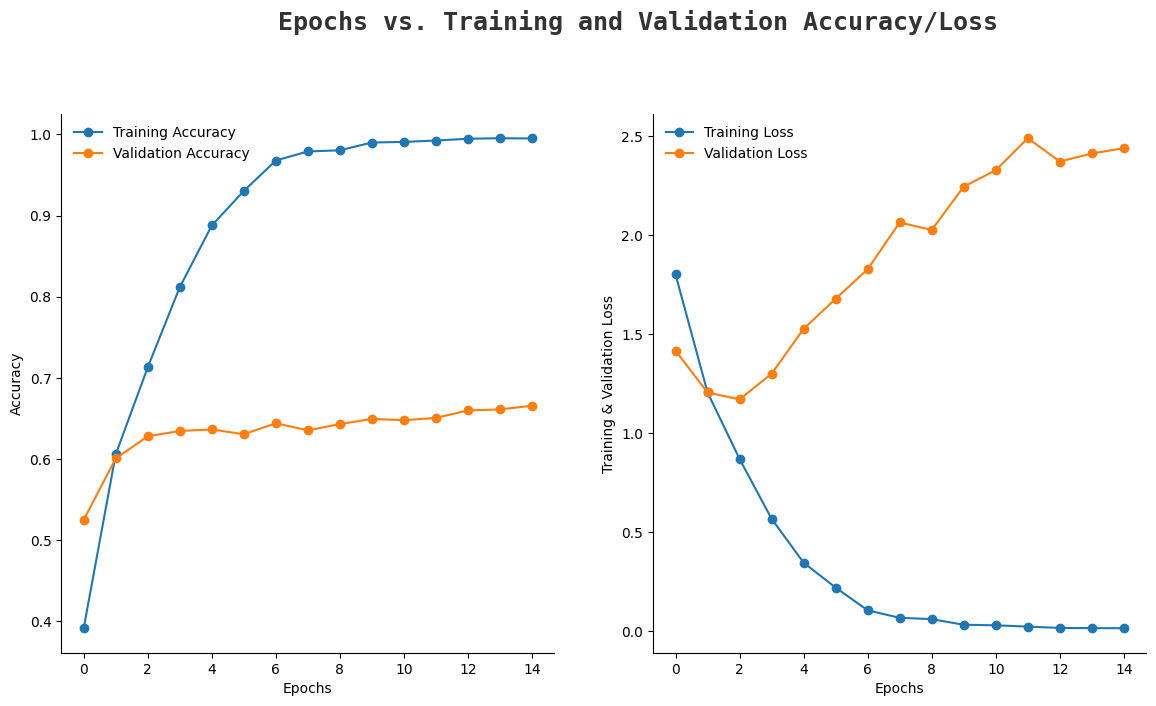

In [40]:
plot_results(history,epochs=15)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       387
           1       0.68      0.70      0.69       395
           2       0.68      0.69      0.69       357
           3       0.48      0.44      0.46       386
           4       0.67      0.79      0.73       409
           5       0.65      0.68      0.66       394
           6       0.67      0.69      0.68       389
           7       0.64      0.56      0.60       419
           8       0.63      0.67      0.65       399
           9       0.80      0.73      0.76       390

    accuracy                           0.67      3925
   macro avg       0.67      0.67      0.66      3925
weighted avg       0.67      0.67      0.66      3925



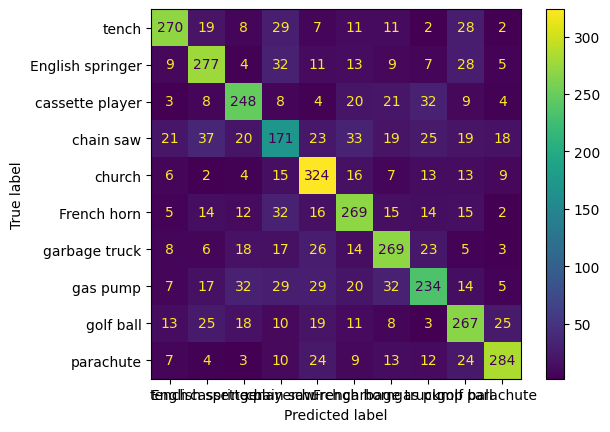

<Figure size 2000x2000 with 0 Axes>

In [41]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)


print(classification_report(y_val_new,pred))

cm = confusion_matrix(y_val_new,pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()

clean_up(model=model)

# Comment on the performance of the optimized model 2

Compare the performance of your optimized model vs the baseline model in terms of accuracy and model size. Comment on the benefits of model optimization for edge devices and embedded systems

Dropout is a common regularization technique, where Dropout(0.3) means that 30% of the neurons in the neural network are randomly “dropped” (i.e., temporarily disabled) during training.It can be added to the first layer and behind each machine learning layer and reduces the dependency between neurons and enhances the generalization of the model.

According to the line graph, the training accuracy and validation accuracy of this model did not change much compared to the original model, but the validation loss decreased significantly,The maximum value of the validation loss decreased from 3 to 2.5,The closer the curve of validation loss is to the bottom, the more successful the model optimization is.The accuracy curve did not change probably because of the following reasons：

1.If Dropout's discard rate is set too low, it may not be effective in preventing overfitting

2.If Dropout's discard rate is set too high, it may result in model underfitting (this has been ruled out)

3.The complexity of the starting model is low (e.g., fewer layers, fewer neurons), the effect of Dropout may not be significant

4.The number of epochs is too low

# 3.BatchNormalization

In [23]:
# new model here(Batch Normalization):

from tensorflow.keras.layers import BatchNormalization

def ImprovedClassifier3(input_shape=(224, 224, 3), num_classes=10):

# Create an instance of the SimpleClassifier model

    model=keras.Sequential([

        BatchNormalization(),
        
        Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(), 
        MaxPooling2D(pool_size=2),
    
   
        Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=2),
    

        Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=2),
    
        Flatten(),
        layers.Dense(units=256,activation='relu'),
        BatchNormalization(), 
        layers.Dense(num_classes, activation='softmax')
        
    ])
    return model
    


# Create an instance of the SimpleClassifier model
model = ImprovedClassifier3()

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# set up a tensorboard and save logs
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/kaggle/working/ImprovedClassifier.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [25]:
# define the learning rate using ReduceLRONPlateau function

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# compile your model

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# fit the model to your training data

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15,
                    batch_size=32,
                    callbacks=[tensorboard, checkpoint,reduce_lr])


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4533 - loss: 1.8347
Epoch 1: val_accuracy improved from -inf to 0.27338, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.4536 - loss: 1.8334 - val_accuracy: 0.2734 - val_loss: 2.7612 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7179 - loss: 0.8681
Epoch 2: val_accuracy improved from 0.27338 to 0.64408, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.7179 - loss: 0.8682 - val_accuracy: 0.6441 - val_loss: 1.1033 - learning_rate: 0.0010
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8515 - loss: 0.4863
Epoch 3: val_accuracy improved from 0.64408 to 0.67159, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.8514 - loss: 0.4862 - val_accuracy: 0.6716 - val_loss: 1.07

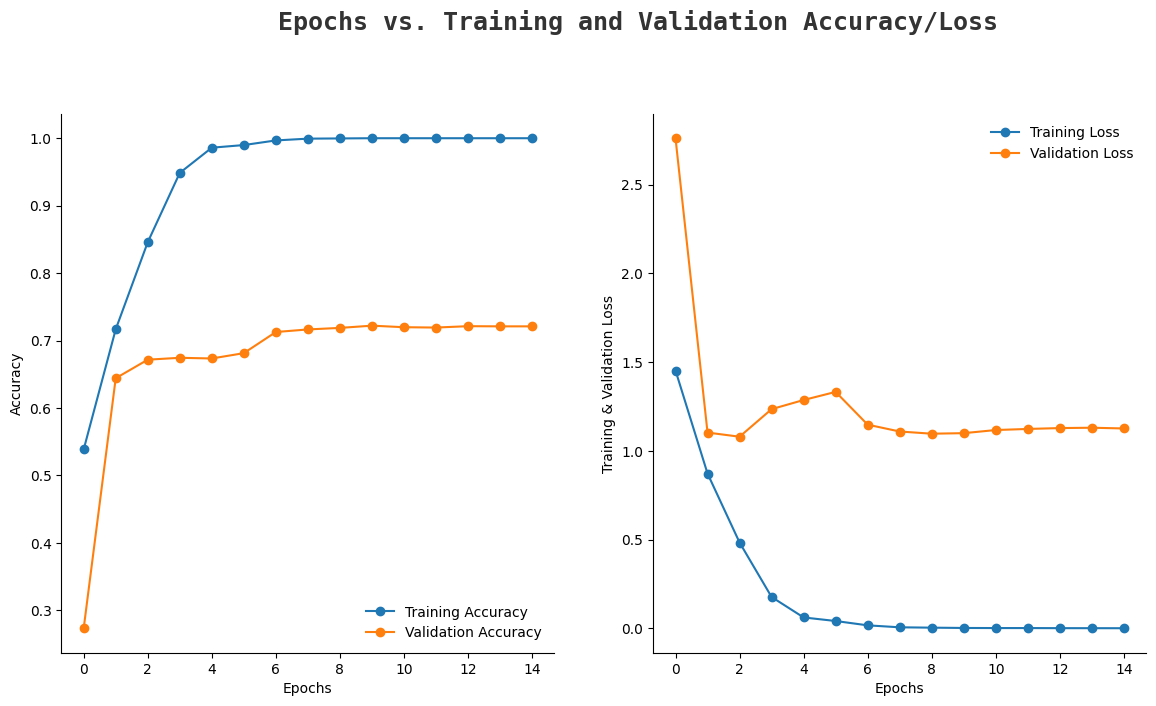

In [26]:
plot_results(history,epochs=15)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       387
           1       0.73      0.77      0.75       395
           2       0.70      0.73      0.72       357
           3       0.56      0.48      0.52       386
           4       0.76      0.80      0.78       409
           5       0.74      0.66      0.70       394
           6       0.74      0.78      0.76       389
           7       0.69      0.65      0.67       419
           8       0.70      0.71      0.71       399
           9       0.80      0.78      0.79       390

    accuracy                           0.72      3925
   macro avg       0.72      0.72      0.72      3925
weighted avg       0.72      0.72      0.72      3925



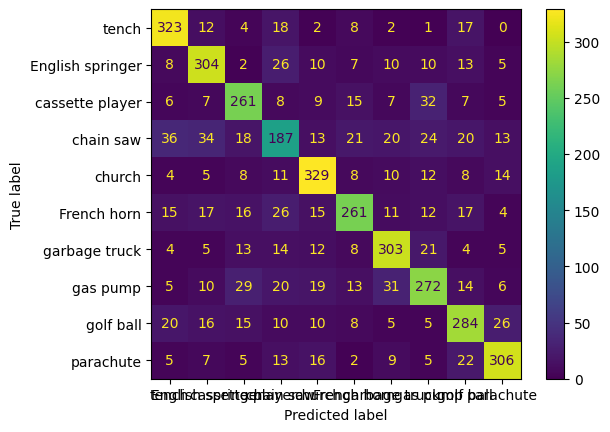

<Figure size 2000x2000 with 0 Axes>

In [27]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)


print(classification_report(y_val_new,pred))

cm = confusion_matrix(y_val_new,pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()

clean_up(model=model)

# Comment on the performance of the optimized model 3

Compare the performance of your optimized model vs the baseline model in terms of accuracy and model size. Comment on the benefits of model optimization for edge devices and embedded systems

BatchNormalization() takes the data input to the neural network and does a translation and scaling transformation on it first, and speeds up convergence when the model is being trained, which can be added after every machine learning or feature extraction layer, and can also be used as the first layer. It can be used without any parameterization.

According to the line graph of the training process of this model, it can be observed that there is a great improvement in this model compared to the original one，This is mainly reflected in the increase in verification accuracy from about 0.6 to about 0.7，The validation loss starts to increase after the third epoch, but the increase is substantially reduced compared to the original model, and decreases and stabilizes after the fifth epoch.The validation loss compared to that of the original model has dropped dramatically from around 3.0 to around 1.0.

The gap between training accuracy and validation accuracy is also relatively reduced, which indicates that the overfitting problem of the model has been effectively mitigated, in addition, the validation loss is stabilized more quickly, and the convergence of the surface model is accelerated, overall batchnormalization is the relatively most efficient optimization approach.

# 4.L2 Regulizer

In [43]:

# new model here(L2 Regularization):

from tensorflow.keras.regularizers import l2

def ImprovedClassifier4(input_shape=(224, 224, 3), num_classes=10):

# Create an instance of the SimpleClassifier model

    model=keras.Sequential([
        
        Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=input_shape, kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=2),
    
   
        Conv2D(filters=64,kernel_size=3,activation='relu',padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=2),
    

        Conv2D(filters=128,kernel_size=3,activation='relu',padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=2),
    
        Flatten(),
        layers.Dense(units=256,activation='relu'),
        layers.Dropout(rate=0.3),
        layers.Dense(num_classes, activation='softmax')
        
    ])
    return model
    


# Create an instance of the SimpleClassifier model
model = ImprovedClassifier4()

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,247,242 (84.87 MB)

 Trainable params: 22,247,242 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# set up a tensorboard and save logs
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/kaggle/working/ImprovedClassifier.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [45]:
# define the learning rate using ReduceLRONPlateau function

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# compile your model

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# fit the model to your training data

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15,
                    batch_size=32,
                    callbacks=[tensorboard, checkpoint,reduce_lr])


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2984 - loss: 2.6357
Epoch 1: val_accuracy improved from -inf to 0.53503, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - accuracy: 0.2987 - loss: 2.6341 - val_accuracy: 0.5350 - val_loss: 1.6907 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5857 - loss: 1.4778
Epoch 2: val_accuracy improved from 0.53503 to 0.60459, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.5857 - loss: 1.4777 - val_accuracy: 0.6046 - val_loss: 1.3715 - learning_rate: 0.0010
Epoch 3/15
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6675 - loss: 1.1778
Epoch 3: val_accuracy improved from 0.60459 to 0.63592, saving model to /kaggle/working/ImprovedClassifier.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6674 - loss: 1.1778 - val_accuracy: 0.6359 - val_loss: 1.268

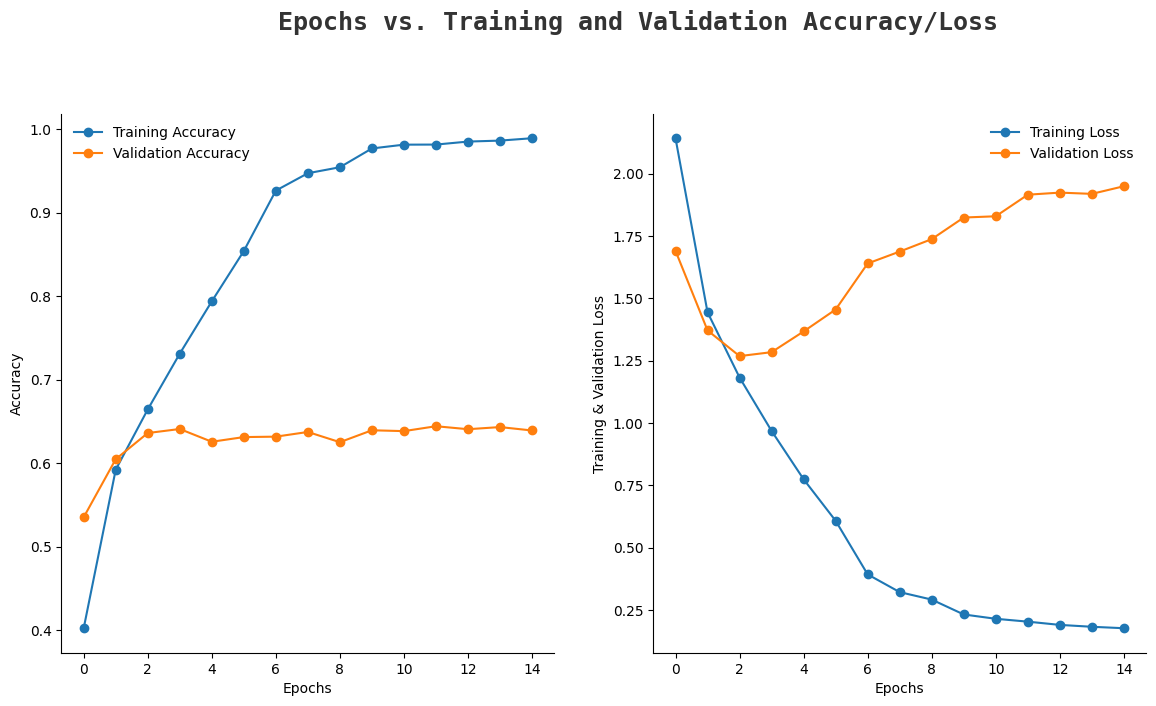

In [46]:
plot_results(history,epochs=15)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       387
           1       0.61      0.75      0.68       395
           2       0.67      0.67      0.67       357
           3       0.47      0.41      0.44       386
           4       0.72      0.74      0.73       409
           5       0.66      0.63      0.64       394
           6       0.65      0.72      0.68       389
           7       0.63      0.58      0.61       419
           8       0.66      0.64      0.65       399
           9       0.74      0.72      0.73       390

    accuracy                           0.66      3925
   macro avg       0.66      0.66      0.66      3925
weighted avg       0.66      0.66      0.66      3925



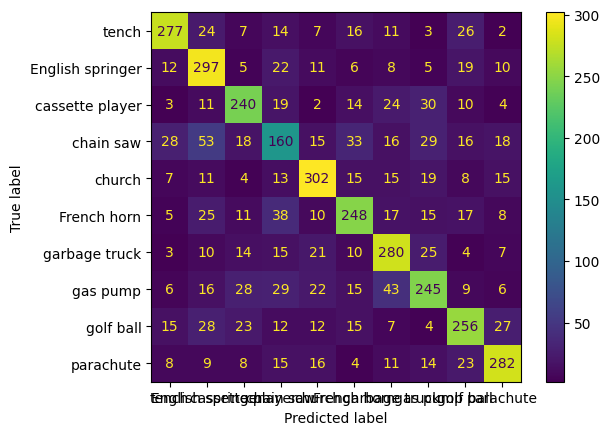

<Figure size 2000x2000 with 0 Axes>

In [35]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)


print(classification_report(y_val_new,pred))

cm = confusion_matrix(y_val_new,pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()

clean_up(model=model)

# Comment on the performance of the optimized model 4

Compare the performance of your optimized model vs the baseline model in terms of accuracy and model size. Comment on the benefits of model optimization for edge devices and embedded systems

The principle of L2 regularization is more complex compared to the above three optimizations.Simply come it will add an extra term to the loss function, and instead of focusing on specific features, the optimized model will learn more general rules from them.

The validation loss in the model optimized by L2 regularization stays at a relatively stable level after the initial (epoch0-3) drop, and although it still tends to rise, it is much more moderate compared to the simple CNN. This indicates that L2 regularization reduces the overfitting of the model on the training data so that the validation loss does not rise sharply.However, the point that cannot be ignored is that the accuracy of the model does not improve significantly compared to before being optimized, both being around 0.6，This may be because the main effect of L2 regularization is to prevent overfitting and does not directly improve the accuracy of the model.Another possibility is that I have set the regularization strength too low or (λ = 0.01), which can be verified by increasing the regularization strength and running.


# 5.DIY Model(Best Pefermence)

In [18]:
# new model here(DIY):


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import RandomRotation


def ImprovedClassifier3(input_shape=(224, 224, 3), num_classes=10):

# Create an instance of the SimpleClassifier model

    model=keras.Sequential([

        BatchNormalization(),
        RandomRotation(factor=0.20),
        
        Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(), 
        MaxPooling2D(pool_size=2),
    
   
        Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=2),
    

        Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=2),
    
        Flatten(),
        layers.Dense(units=256,activation='relu'),
        BatchNormalization(), 
        layers.Dense(num_classes, activation='softmax')
        
    ])
    return model
    


# Create an instance of the SimpleClassifier model
model = ImprovedClassifier3()

# Display model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# set up a tensorboard and save logs
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/kaggle/working/DIY.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [21]:
# define the learning rate using ReduceLRONPlateau function

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# compile your model

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# fit the model to your training data

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15,
                    batch_size=32,
                    callbacks=[tensorboard, checkpoint,reduce_lr])


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3909 - loss: 2.0518
Epoch 1: val_accuracy improved from -inf to 0.22904, saving model to /kaggle/working/DIY.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 63s 179ms/step - accuracy: 0.3912 - loss: 2.0506 - val_accuracy: 0.2290 - val_loss: 3.2866 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5558 - loss: 1.3692
Epoch 2: val_accuracy improved from 0.22904 to 0.57376, saving model to /kaggle/working/DIY.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.5559 - loss: 1.3690 - val_accuracy: 0.5738 - val_loss: 1.3466 - learning_rate: 0.0010
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6046 - loss: 1.1902
Epoch 3: val_accuracy improved from 0.57376 to 0.59567, saving model to /kaggle/working/DIY.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.6046 - loss: 1.1902 - val_accuracy: 0.5957 - val_loss: 1.2829 - learning_rate: 0.0010
Epoch 4/15
29

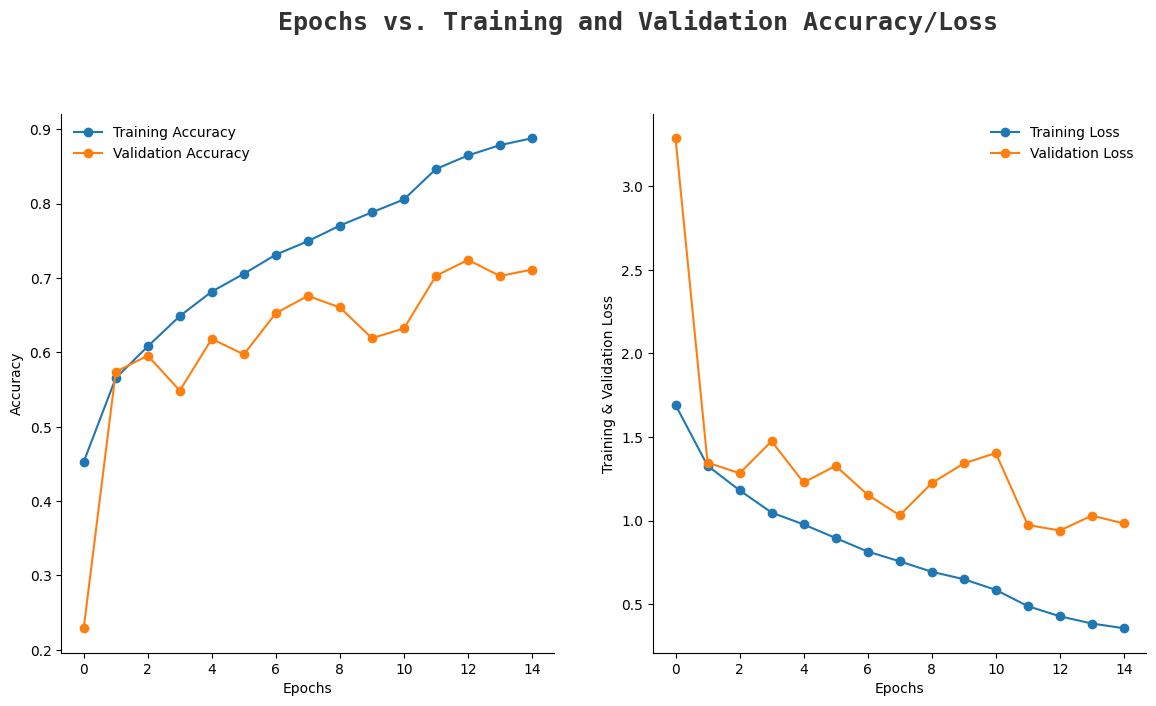

In [24]:
plot_results(history,epochs=15)

123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       387
           1       0.94      0.67      0.78       395
           2       0.78      0.71      0.74       357
           3       0.52      0.67      0.59       386
           4       0.56      0.85      0.68       409
           5       0.79      0.73      0.76       394
           6       0.81      0.64      0.72       389
           7       0.55      0.59      0.57       419
           8       0.76      0.73      0.75       399
           9       0.79      0.76      0.78       390

    accuracy                           0.71      3925
   macro avg       0.74      0.71      0.72      3925
weighted avg       0.74      0.71      0.72      3925



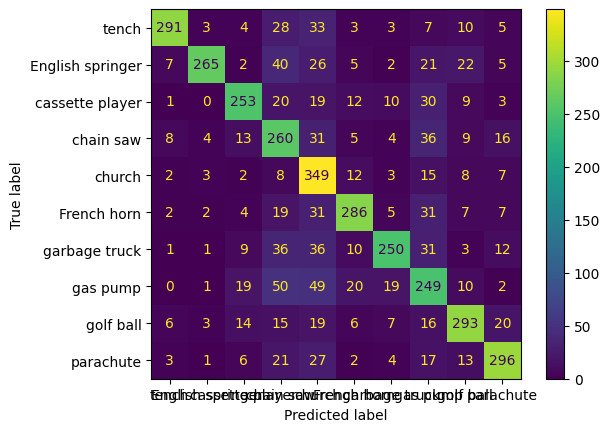

<Figure size 2000x2000 with 0 Axes>

NameError: name 'clean_up' is not defined

In [25]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)


print(classification_report(y_val_new,pred))

cm = confusion_matrix(y_val_new,pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()

clean_up(model=model)

## Implement an optimized model
When applying our model to embedded/edge devices, it is important to optimize the model i.e. smaller, faster inference on edge devices. To do this, we can use the converter function from the tensorflow TFLite library.

In this section, you will take your best model, and convert it to a TFLite model. Follow this guideline https://www.kaggle.com/code/ashusma/understanding-tf-lite-and-model-optimization

Apply post-training quantization to reduce the size of your model. Also, export your model as a concrete function (see guide for details)

Note: Configure the model as a float16 implementation, as the Jetson Nano is a float16 processor.

When finished, save your output model.

Comment on the model size and performance trade-offs of the optimized model vs the original model

In [4]:
model = tf.keras.models.load_model('/kaggle/working/simpleClassifier.keras')



# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/kaggle/working/NEWmodel.tflite', 'wb') as f:
  f.write(tflite_model)



Saved artifact at '/tmp/tmpqrl2jxq7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133964192319088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192324016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192366832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192369120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192380384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192377216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192382320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192452272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192454384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133964192457200: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [26]:
model = tf.keras.models.load_model('/kaggle/working/DIY.keras')



# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/kaggle/working/NEWmodel2.tflite', 'wb') as f:
  f.write(tflite_model)



Saved artifact at '/tmp/tmp1w62qoev'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133961730955168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730957456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730950416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730952880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730993040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730989168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730995152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730996912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730993744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133961730995680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13396173107232

In [11]:
def evaluate_model(interpreter):
    # Get input and output tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Ensure input shape matches model requirements
    input_shape = input_details[0]['shape']  # Expected shape: (1, 224, 224, 3)
    X_val_resized = X_val.astype(np.float32)  # Ensure correct data type
    
    # Run inference on the validation set
    correct_predictions = 0
    total_samples = len(X_val_resized)
    
    print("\nEvaluating TFLite model on validation dataset...\n")
    
    for i in tqdm(range(total_samples), desc="Progress", unit="img"):
        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X_val_resized[i], axis=0))
    
        # Run inference
        interpreter.invoke()
    
        # Get output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        # Get predicted class and true class
        predicted_label = np.argmax(output_data)
        true_label = np.argmax(y_val[i])  # Since y_val is one-hot encoded
    
        if predicted_label == true_label:
            correct_predictions += 1
    
    return correct_predictions / total_samples

In [27]:
# run the helper function to test the accuracy
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/NEWmodel2.tflite")
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Optimized model test accuracy:', test_accuracy)


Evaluating TFLite model on validation dataset...



Progress: 100%|██████████| 3925/3925 [01:43<00:00, 38.09img/s]

Optimized model test accuracy: 0.7243312101910828


## Comment on the performance of the optimized model
Compare the performance of your optimized model vs the baseline model in terms of accuracy and model size. Comment on the benefits of model optimization for edge devices and embedded systems

This optimization converts the original Keras model into TFLite format, Lite Convertion is generally aimed at improving the efficiency of the model running on mobile or embedded devices.TFlite conversion comes with quantization，which converts the model's computations and stored data formats into smaller,and further compress the size of the model to improve operational efficiency.

I did a TFlite conversion for both the original model and my self-created DIY model,From the results, the TFlite version of the model still maintains its original accuracy (64% for the original model and 72.4% for the DIY model),It can be shown that the TFLite conversion does not lead to a significant loss of accuracy,However, the size of the model file is reduced(from 309mb to 89mb), and the computational cost is greatly reduced, which is suitable for embedded devices and other occasions where computational resources are limited.Overall TFLite is a positive optimization.



